In [4]:
#import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import seaborn as sn
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc,accuracy_score

In [ ]:
# Count Train test data
train_dir = '/content/train'
test_dir = '/content/test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = f"{path}/{expression}"
        print(dir_)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

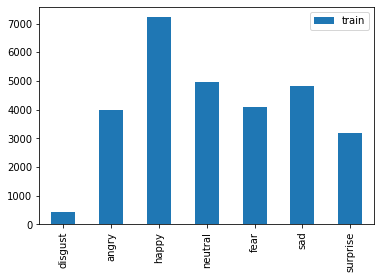

In [6]:
# plot count of data train
train_count.transpose().plot(kind='bar')

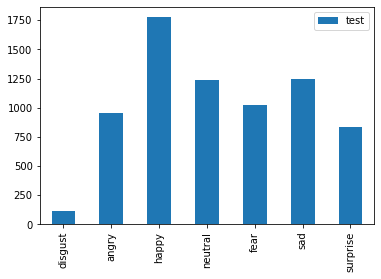

In [7]:
# plot count of data test
test_count.transpose().plot(kind='bar')

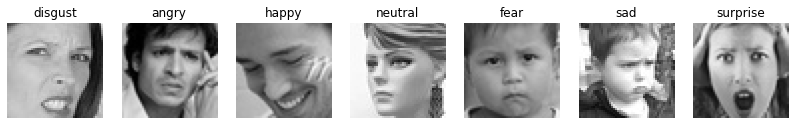

In [8]:
# show some random images
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
  pa = os.listdir(f"{train_dir}/{expression}")[1]
  path_img = (f"{train_dir}/{expression}/{pa}")
  img = load_img(path_img)
  plt.subplot(1,7,i)
  plt.imshow(img)
  plt.title(expression)
  plt.axis('off')
  i += 1
plt.show()

In [9]:
# load data and set ImageDataGenerator for generate images

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# show class
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [11]:
#define CNN Model
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [12]:
#Show Model Summary
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
# set callback functions
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [14]:
# train our Model
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=70,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/70
448/448 [==============================] - 96s 193ms/step - loss: 11.0738 - accuracy: 0.2974 - val_loss: 7.6227 - val_accuracy: 0.2266

Epoch 00001: val_loss improved from inf to 7.62272, saving model to ferNet.h5
Epoch 2/70
448/448 [==============================] - 82s 183ms/step - loss: 5.4877 - accuracy: 0.3975 - val_loss: 4.1335 - val_accuracy: 0.3813

Epoch 00002: val_loss improved from 7.62272 to 4.13350, saving model to ferNet.h5
Epoch 3/70
448/448 [==============================] - 82s 183ms/step - loss: 3.3052 - accuracy: 0.4529 - val_loss: 2.6259 - val_accuracy: 0.4854

Epoch 00003: val_loss improved from 4.13350 to 2.62594, saving model to ferNet.h5
Epoch 4/70
448/448 [==============================] - 82s 182ms/step - loss: 2.3163 - accuracy: 0.4886 - val_loss: 1.9574 - val_accuracy: 0.5259

Epoch 00004: val_loss improved from 2.62594 to 1.95743, saving model to ferNet.h5
Epoch 5/70
448/448 [==============================] - 82s 183ms/step - loss: 1.8402 - accur

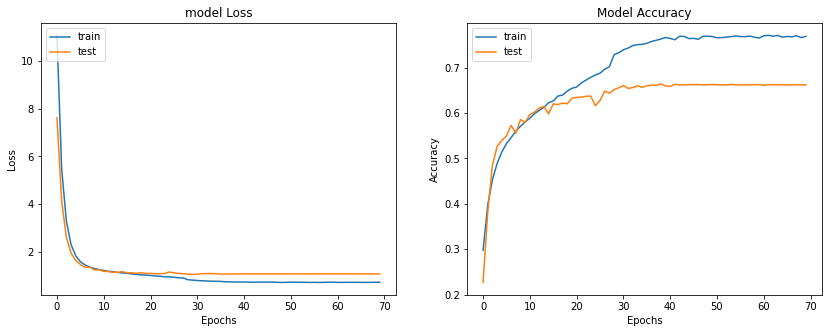

In [15]:
# plot train and test accuracy and loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 6s 54ms/step - loss: 1.0796 - accuracy: 0.6620
final train accuracy = 83.26 , validation accuracy = 66.20


In [ ]:
# save model structure in jason file
model_json = fernet.to_json()
with open("emotion_model_cnn.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
fernet.save_weights('emotion_model_cnn.h5')

In [ ]:
# Confusion Matrix and Classification Report of training set
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

sn.heatmap(cm_train, annot=True,cmap="OrRd",fmt=".1f")
plt.show()

Confusion Matrix
[[135   9 121 249 184 158 102]
 [ 17   2  13  27  14  21  17]
 [143   7 126 238 213 173 124]
 [264  17 220 424 368 282 199]
 [174  14 132 343 221 205 144]
 [172  10 147 294 248 220 156]
 [114  12 103 210 161 141  90]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.03      0.02      0.02       111
        fear       0.15      0.12      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.16      0.18      0.17      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



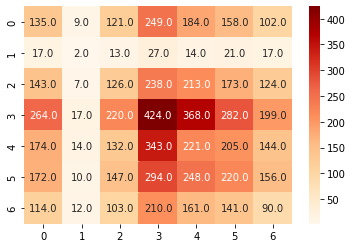

In [19]:
# Confusion Matrix and Classification Report of test set
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

sn.heatmap(cm_test, annot=True,cmap="OrRd",fmt=".1f")
plt.show()

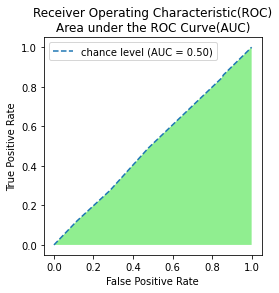

In [20]:
#Receiver Operating Characteristic(ROC) And 
fpr, tpr, thresholds = roc_curve(np.array(test_set.classes), np.array(fernet.predict(test_set).argmax(axis=1)), pos_label=2)
#roc_curve(test_set.classes,y_pred, pos_label=2)
auc_r = "{:.2f}".format(auc(fpr, tpr))
plt.plot(fpr,tpr, "--",label=f"chance level (AUC = {auc_r})")
plt.fill_between(fpr, tpr, facecolor='lightgreen')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic(ROC)\nArea under the ROC Curve(AUC)")
plt.legend()
plt.show()